In [1]:
NAME = "pipeflow"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

# print(tf.config.list_physical_devices('GPU'))

In [3]:
def generate_model(layers, adaptive = False):
	class swish(keras.layers.Layer):
		def __init__(self, adaptive):
			super(swish, self).__init__()
			if adaptive:
				self.beta = tf.Variable(1.0, dtype = tf.float32, trainable = True)
			else:
				self.beta = tf.constant(1.0, dtype = tf.float32)
			
		def call(self, inputs):
			return inputs*tf.math.sigmoid(inputs*self.beta)
	
	with tf.device("cpu"):
		model = keras.models.Sequential()
		for i in range(len(layers)-2):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = None,
                                        kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform"))
			model.add(swish(adaptive))
		model.add(keras.layers.Dense(layers[-1], activation = None,
                                    kernel_initializer = "glorot_uniform", bias_initializer = "glorot_uniform"))
	return model

layers = [4, 50, 50, 50, 1]
model_u = generate_model(layers, True)
model_v = generate_model(layers, True)
model_p = generate_model(layers, True)

In [4]:
R = 0.05
L = 1.0

x_start = 0
x_end = x_start + L 
y_start = -R
y_end = y_start + 2*R

nu_mean = 0.001
nu_std = 0.9
nu_start = nu_mean*(1-nu_std)
nu_end = nu_mean*(1+nu_std)

dp = 0.1
rho = 1.0

In [5]:
loss_func = keras.losses.MeanSquaredError()

def step(x, y, nu):
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x, y, nu])
		b = 2*np.pi/(x_end - x_start)
		c = np.pi*(x_start + x_end)/(x_start - x_end)
		sin_x = x_start*tf.sin(b*x+c)
		cos_x = x_start*tf.cos(b*x+c)
		xx = tf.concat([sin_x, cos_x, y, nu], axis = 1)
		u = model_u(xx)*(R**2 - tf.square(y))
		v = model_v(xx)*(R**2 - tf.square(y))
		p = model_p(xx)*(x_start - x)*(x_end - x) + (x_start - x)*0 + dp*(x_end - x)/L + 0*y
		du_dx = tape.gradient(u, x)
		du_dy = tape.gradient(u, y)
		du_dxx = tape.gradient(du_dx, x)
		du_dyy = tape.gradient(du_dy, y)
		dv_dx = tape.gradient(v, x)
		dv_dy = tape.gradient(v, y)
		dv_dxx = tape.gradient(dv_dx, x)
		dv_dyy = tape.gradient(dv_dy, y)
		dp_dx = tape.gradient(p, x)
		dp_dy = tape.gradient(p, y)
		eq1 = u*du_dx + v*du_dy + 1/rho*dp_dx - nu*(du_dxx + du_dyy)
		eq2 = u*dv_dx + v*dv_dy + 1/rho*dp_dy - nu*(dv_dxx + dv_dyy)
		eq3 = du_dx + dv_dy
		loss = loss_func(eq1, 0.0) + loss_func(eq2, 0.0) + loss_func(eq3, 0.0)
	grads_u = tape.gradient(loss, model_u.trainable_variables)
	grads_v = tape.gradient(loss, model_v.trainable_variables)
	grads_p = tape.gradient(loss, model_p.trainable_variables)
	optimizer_u.apply_gradients(zip(grads_u, model_u.trainable_variables))
	optimizer_v.apply_gradients(zip(grads_v, model_v.trainable_variables))
	optimizer_p.apply_gradients(zip(grads_p, model_p.trainable_variables))
	del tape
	return loss
	
def train(data, start_epoch, epochs, batch_size, print_every, save_every, save_path):
	data_ = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size = data[0].shape[0], \
															reshuffle_each_iteration = True).batch(batch_size)
	for epoch in range(start_epoch+1, start_epoch+epochs+1):
		losses = 0
		count = 0
		for (x, y, nu) in data_:
			loss = step(x, y, nu)
			losses += loss
			count += 1
		losses /= count
		
		if (epoch-start_epoch) % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}".format(get_time(), epoch, losses))
		if (epoch-start_epoch) % save_every == 0:
			model_u.save("models/{}/{}/checkpoint_{}/model_u".format(NAME, save_path, epoch))
			model_v.save("models/{}/{}/checkpoint_{}/model_v".format(NAME, save_path, epoch))
			model_p.save("models/{}/{}/checkpoint_{}/model_p".format(NAME, save_path, epoch))

In [12]:
Nx = 10
Ny = 50
Np = 50

x = np.linspace(x_start, x_end, Nx)
y = np.linspace(y_start, y_end, Ny)
nu = np.linspace(nu_start, nu_end, Np)
xynu = tensor_grid([nu, x, y])

x, y, nu = map(lambda x: tf.constant(x, dtype = tf.float32), [xynu[:, 1:2], xynu[:, 2:3], xynu[:, 0:1]])
data = (x, y, nu)

import pickle
with open("dataset_{}.pkl".format(NAME), "wb") as file:
	pickle.dump(data, file)

In [7]:
import pickle
with open("dataset_{}.pkl".format(NAME), "rb") as file:
	data = pickle.load(file)

In [8]:
optimizer_u = keras.optimizers.Adam(learning_rate = 5e-3)
optimizer_v = keras.optimizers.Adam(learning_rate = 5e-3)
optimizer_p = keras.optimizers.Adam(learning_rate = 5e-3)

train(data, start_epoch = 0, epochs = 1000, batch_size = 128, print_every = 2, save_every = 200, save_path = "1")

2020/07/13, 12:13:26, Epoch: 2, Loss: 2.2081e-03
2020/07/13, 12:14:50, Epoch: 4, Loss: 2.2140e-03
2020/07/13, 12:15:52, Epoch: 6, Loss: 2.2259e-03
2020/07/13, 12:16:55, Epoch: 8, Loss: 2.2173e-03
2020/07/13, 12:17:57, Epoch: 10, Loss: 2.0410e-03
2020/07/13, 12:18:59, Epoch: 12, Loss: 9.2448e-04
2020/07/13, 12:20:02, Epoch: 14, Loss: 8.5349e-04
2020/07/13, 12:21:05, Epoch: 16, Loss: 8.0261e-04
2020/07/13, 12:22:08, Epoch: 18, Loss: 7.9478e-04
2020/07/13, 12:23:52, Epoch: 20, Loss: 6.7943e-04
2020/07/13, 12:25:50, Epoch: 22, Loss: 3.3490e-04
2020/07/13, 12:27:37, Epoch: 24, Loss: 2.1499e-04
2020/07/13, 12:29:42, Epoch: 26, Loss: 2.2535e-04
2020/07/13, 12:31:48, Epoch: 28, Loss: 1.3016e-04
2020/07/13, 12:33:45, Epoch: 30, Loss: 1.6839e-04
2020/07/13, 12:35:45, Epoch: 32, Loss: 8.7004e-05
2020/07/13, 12:37:51, Epoch: 34, Loss: 1.0813e-04
2020/07/13, 12:39:56, Epoch: 36, Loss: 6.3632e-05
2020/07/13, 12:41:56, Epoch: 38, Loss: 1.2494e-04
2020/07/13, 12:44:01, Epoch: 40, Loss: 5.6579e-05
2020

2020/07/13, 14:20:12, Epoch: 170, Loss: 2.2255e-05
2020/07/13, 14:21:53, Epoch: 172, Loss: 3.7404e-05
2020/07/13, 14:23:10, Epoch: 174, Loss: 6.3182e-06
2020/07/13, 14:24:38, Epoch: 176, Loss: 2.5055e-05
2020/07/13, 14:26:04, Epoch: 178, Loss: 5.4288e-05
2020/07/13, 14:27:59, Epoch: 180, Loss: 7.2082e-06
2020/07/13, 14:29:57, Epoch: 182, Loss: 7.3832e-06
2020/07/13, 14:31:58, Epoch: 184, Loss: 1.6535e-05
2020/07/13, 14:33:56, Epoch: 186, Loss: 1.9594e-05
2020/07/13, 14:35:57, Epoch: 188, Loss: 2.0187e-05
2020/07/13, 14:37:52, Epoch: 190, Loss: 5.9198e-05
2020/07/13, 14:39:49, Epoch: 192, Loss: 3.4334e-05
2020/07/13, 14:41:56, Epoch: 194, Loss: 4.3285e-06
2020/07/13, 14:44:00, Epoch: 196, Loss: 1.8616e-05
2020/07/13, 14:46:04, Epoch: 198, Loss: 9.2387e-06
2020/07/13, 14:48:05, Epoch: 200, Loss: 8.0741e-06
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/pipeflow/1/checkpoint_200/model_u/assets
INFO:tensorflow:Asse

KeyboardInterrupt: 

In [13]:
b = 2*np.pi/(x_end - x_start)
c = np.pi*(x_start + x_end)/(x_start - x_end)
sin_x_ = x_start*tf.sin(b*x+c)
cos_x_ = x_start*tf.cos(b*x+c)
xx = tf.concat([sin_x_, cos_x_, y, nu], axis = 1)

u_pred = model_u(xx)*(R**2 - tf.square(y))
v_pred = model_v(xx)*(R**2 - tf.square(y))
p_pred = model_p(xx)*(x_start - x)*(x_end - x) + (x_start - x)*0 + dp*(x_end - x)/L + 0*y

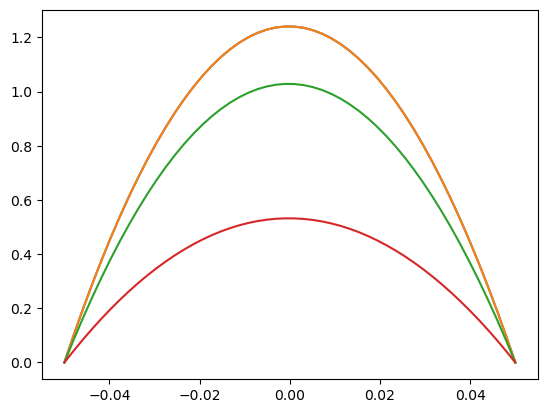

In [14]:
import matplotlib.pyplot as plt

x = [0.5]
y = np.linspace(y_start, y_end, Ny)
nu = np.linspace(nu_start, nu_end, Np)
xynu = tensor_grid([nu, x, y])

x, y, nu = map(lambda x: tf.constant(x, dtype = tf.float32), [xynu[:, 1:2], xynu[:, 2:3], xynu[:, 0:1]])

index_p = [3, 6, 14, 49]
y = np.linspace(y_start, y_end, Ny)
for index_p_ in index_p:
	plt.plot(y, u_pred[index_p_*Ny:(index_p_+1)*Ny, :])
plt.show()